In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import sys
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from sklearn import metrics
import pandas as pd
import cv2
import keras
import tensorflow as tf
from tensorflow.keras.applications import mobilenet,mobilenet_v2,inception_v3,efficientnet
import tensorflow_model_optimization as tfmot

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
train_dir = r'C:\Users\nikita\CourseWork\NIH_CHEST\train'
val_dir = r'C:\Users\nikita\CourseWork\NIH_CHEST\val'
test_dir = r'C:\Users\nikita\CourseWork\NIH_CHEST\test'

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

# Creating Data Generators

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [34]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

print("Overall found", (train_data.samples + val_data.samples + test_data.samples), 'images')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Overall found 5856 images


**DESTRIBUTION OF DATA** 

In [28]:
def show_destribution():
    x_axes = np.arange(3)
    y_axes = []
    for train_el in range(train_data.samples):
        y_axes.append(2)
    for val_el in range(val_data.samples):
        y_axes.append(1)
    for test_el in range(test_data.samples):
        y_axes.append(3)
    
    fig = plt.figure(figsize=(12, 9))
    plt.hist(x=y_axes, bins=3, zorder=2, rwidth=0.9)
    plt.xlabel('Train, Val and Test')
    plt.ylabel('Number of ...')

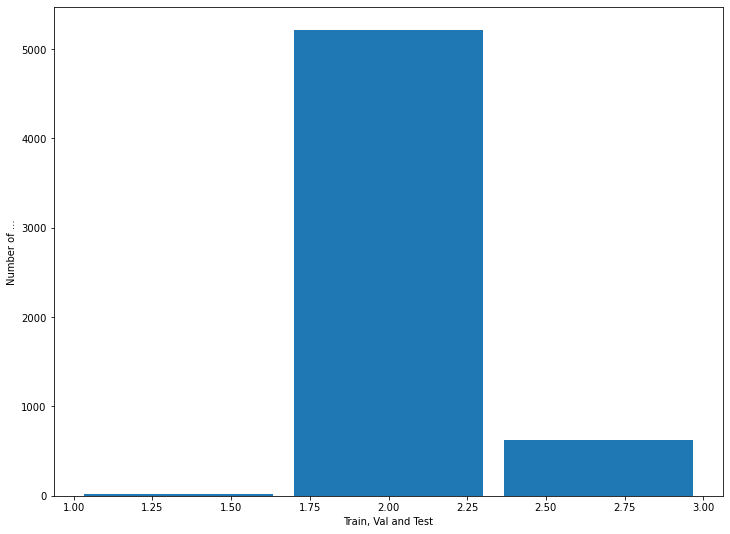

In [29]:
show_destribution()

# Building the Model

In [35]:
print("input 1 for mobile_net, 2 for resnet, 3 for Xception ", end='')

choice = int(input())

if (choice == 1):
    model_general=tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
    )
    model_general.trainable = False
elif (choice == 2):
    model_general=tf.keras.applications.VGG19(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
    )
    model_general.trainable = False
elif (choice == 3):
    model_general=tf.keras.applications.Xception(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
    )
    model_general.trainable = False
else:
    print("!wrong input")

input 1 for mobile_net, 2 for resnet, 3 for Xception 3


In [36]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = model_general(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,960,681
Trainable params: 2,099,201
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [38]:
EPOCHS = 5

callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1),
    tf.keras.callbacks.ModelCheckpoint("NIH_model_1.h5",save_best_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=1, min_delta = 0.001,
                                      min_lr=0.000001,
                                      mode = 'min',verbose=1)]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/5
163/163 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9266 - auc: 0.9718
Epoch 1: val_loss improved from inf to 0.30431, saving model to NIH_model_1.h5
163/163 [==============================] - 97s 580ms/step - loss: 0.1830 - accuracy: 0.9266 - auc: 0.9718 - val_loss: 0.3043 - val_accuracy: 0.9375 - val_auc: 0.9531 - lr: 0.0010
Epoch 2/5
163/163 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9438 - auc: 0.9854
Epoch 2: val_loss did not improve from 0.30431

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
163/163 [==============================] - 94s 576ms/step - loss: 0.1328 - accuracy: 0.9438 - auc: 0.9854 - val_loss: 0.4271 - val_accuracy: 0.8125 - val_auc: 0.8984 - lr: 0.0010
Epoch 3/5
163/163 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9530 - auc: 0.9890
Epoch 3: val_loss did not improve from 0.30431

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.00000004

# Results

In [39]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

C:\Users\nikita\AppData\Local\Temp/ipykernel_16688/1857651140.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))


In [40]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

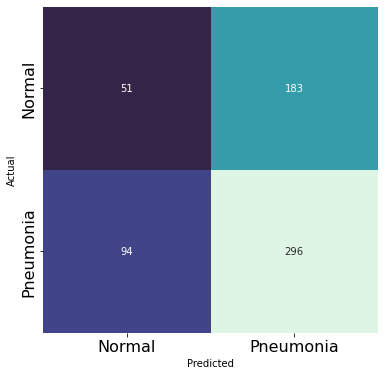

In [41]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [42]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [43]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [44]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.81
AUC: 0.93
Precision: 0.62
Recall: 0.76


In [45]:
def loss_and_accur_through_epochs(history):
    print("- the Accuracy and Loss for custom Model With 10 Epochs")
    plt.figure(figsize=(40,20))



    # summarize history for accuracy 
    plt.subplot(5,5,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper left')



    # summarize history for loss
    plt.subplot(5,5,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','loss'], loc='upper left')
    plt.show()

- the Accuracy and Loss for custom Model With 10 Epochs


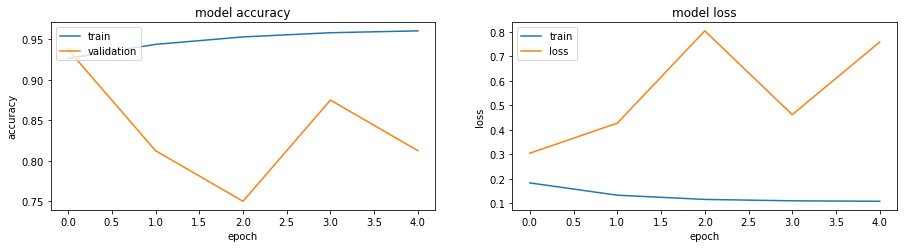

In [46]:
loss_and_accur_through_epochs(history=history)

**POST-TRAINING QUANTIZATION**

In [53]:
def SizeOfNet(model: bytes):
    print("Size -->", len(model), "bytes")
    return len(model)

def reducement_of_size(before, after):
    plt.figure(figsize=(12,9))
    x_before = np.zeros(shape=(1, before))
    x_after = np.ones(shape=(1, after))
    
    x_axes = np.append(x_before, x_after)
    plt.hist(x=x_axes, bins=2, zorder=2, rwidth=0.9)
    plt.xlabel('Before and After PTQ')
    plt.ylabel('Size of a model')
    plt.suptitle("- The reducement in size of net")

In [64]:
import random
def another_representative_dataset():
    base_dir=r'C:\Users\nikita\CourseWork\NIH_CHEST\train'
    train_synsets=os.listdir(base_dir)
    for _ in train_synsets[:100]:
        test_iamge = get_img(base_dir+'\\'+_)
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        test_image = net_model.preprocess_input(test_image)
        yield [test_image]

def get_img(img_path):
    if False:
        img = image.load_img(img_path, target_size=(224,224))
    else:
        img = Image.open(img_path)
        img=img.convert('RGB')
        img = torch_preprocess(img)
    return img

another_representative_dataset()

<generator object another_representative_dataset at 0x000002848D261430>

In [48]:
# converter = tf.lite.TFLiteConverter.from_saved_model('./saved_models')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
my_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpjv356rkb\assets


In [50]:
before_quant = SizeOfNet(my_tflite_model)

Size --> 91573332 bytes


In [66]:
# converter_lite = tf.lite.TFLiteConverter.from_saved_model('./saved_models')
converter_lite = tf.lite.TFLiteConverter.from_keras_model(model)
converter_lite.optimizations = [tf.lite.Optimize.DEFAULT]

print("Input 1 for only integer, 2 for float16, 3 for dynamic")
quant_choice = int(input())
if (quant_choice == 1):
    converter_lite.representative_dataset = another_representative_dataset
    converter_lite.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_lite.inference_input_type = tf.int8  # or tf.uint8
    converter_lite.inference_output_type = tf.int8  # or tf.uint8
    converter_lite.representative_dataset = another_representative_dataset
    my_tflite_quant_model = converter_lite.convert()
elif (quant_choice == 2):
    converter_lite.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_lite.target_spec.supported_types = [tf.float16]
    converter_lite.representative_dataset = another_representative_dataset
    my_tflite_quant_model = converter_lite.convert()
elif (quant_choice == 3):
    converter_lite.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_lite.representative_dataset = another_representative_dataset
    my_tflite_quant_model = converter_lite.convert()
else:
    print("!Wrong input")

Input 1 for only integer, 2 for float16, 3 for dynamic
2
INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpcg_546aw\assets


INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpcg_546aw\assets


In [67]:
with open("my_tflite_quant_model.tflite", "wb") as f:
    f.write(my_tflite_quant_model)

In [68]:
after_quant = SizeOfNet(my_tflite_quant_model)

Size --> 45829488 bytes


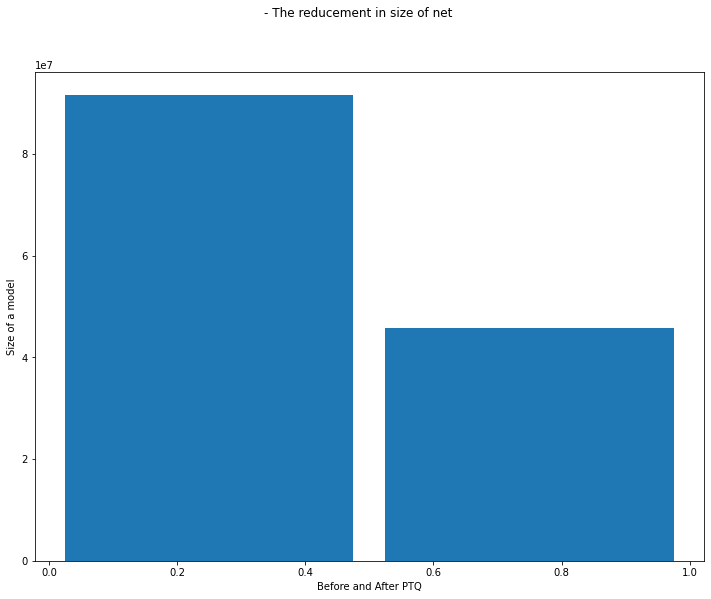

In [69]:
reducement_of_size(before=before_quant, after=after_quant)

In [74]:
interpreter = tf.lite.Interpreter(model_content=my_tflite_quant_model, num_threads=8)
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print('input: ', input_details)
print('output: ', output_details)
interpreter.allocate_tensors()

input:  {'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 230, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
